# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 6

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [ ]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.511
[2] loss: 0.401
[3] loss: 0.161
[4] loss: 0.057
[5] loss: 0.029
[6] loss: 0.021
[7] loss: 0.013
[8] loss: 0.011
[9] loss: 0.010
[10] loss: 0.006
[11] loss: 0.008
[12] loss: 0.006
[13] loss: 0.005
[14] loss: 0.005
[15] loss: 0.004
[16] loss: 0.004


In [ ]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

In [ ]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [ ]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [ ]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [ ]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

In [ ]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [ ]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [ ]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [ ]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [3]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_2.cfg')

['./config/sswae_dev2_1_2.cfg']

In [4]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 6
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 6
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.309964e-01  D: 6.914686e-01  D2: 4.565471e-02  D3: 2.224933e-03
test loss: 1.709167e-01  D: 6.940291e-01  D2: 1.641529e-02  D3: 8.784562e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.643511e-01  D: 6.937345e-01  D2: 4.938421e-03  D3: 6.865458e-03
test loss: 1.459724e-01  D: 6.915060e-01  D2: 3.321428e-03  D3: 6.158170e-03


[default |INFO|model.py:1280] [03/80]  loss: 1.454247e-01  D: 7.019718e-01  D2: 2.029611e-03  D3: 8.560735e-03
test loss: 1.453843e-01  D: 7.069446e-01  D2: 9.123135e-04  D3: 1.268479e-02


[default |INFO|model.py:1280] [04/80]  loss: 1.393095e-01  D: 6.993032e-01  D2: 1.649043e-03  D3: 1.425499e-02
test loss: 1.390566e-01  D: 6.765196e-01  D2: 1.792336e-03  D3: 1.688435e-02


[default |INFO|model.py:1280] [05/80]  loss: 1.211316e-01  D: 6.912728e-01  D2: -5.078141e-04  D3: 1.378832e-02
test loss: 1.012931e-01  D: 6.947902e-01  D2: -1.247902e-03  D3: 7.481517e-03


[default |INFO|model.py:1280] [06/80]  loss: 9.733649e-02  D: 6.944224e-01  D2: -2.094143e-03  D3: 1.467254e-02
test loss: 8.862395e-02  D: 6.974002e-01  D2: -2.804346e-03  D3: 1.567409e-02


[default |INFO|model.py:1280] [07/80]  loss: 8.476484e-02  D: 6.943569e-01  D2: -3.791731e-03  D3: 1.556768e-02
test loss: 7.988434e-02  D: 7.006914e-01  D2: -3.020315e-03  D3: 1.541352e-02


[default |INFO|model.py:1280] [08/80]  loss: 7.853455e-02  D: 6.941342e-01  D2: -4.335672e-03  D3: 1.520710e-02
test loss: 7.660141e-02  D: 6.740220e-01  D2: -4.548254e-03  D3: 1.593993e-02


[default |INFO|model.py:1280] [09/80]  loss: 7.554957e-02  D: 6.936618e-01  D2: -4.445445e-03  D3: 1.505112e-02
test loss: 7.400860e-02  D: 6.931520e-01  D2: -5.074577e-03  D3: 1.607591e-02


[default |INFO|model.py:1280] [10/80]  loss: 7.238147e-02  D: 6.937117e-01  D2: -5.002138e-03  D3: 1.458267e-02
test loss: 6.757819e-02  D: 6.945821e-01  D2: -4.980803e-03  D3: 1.451469e-02


[default |INFO|model.py:1280] [11/80]  loss: 6.952390e-02  D: 6.955330e-01  D2: -4.831702e-03  D3: 1.475433e-02
test loss: 6.869011e-02  D: 6.711460e-01  D2: -5.668411e-03  D3: 1.357706e-02


[default |INFO|model.py:1280] [12/80]  loss: 6.819074e-02  D: 6.934071e-01  D2: -5.273763e-03  D3: 1.415313e-02
test loss: 6.422729e-02  D: 7.062536e-01  D2: -5.866337e-03  D3: 1.578397e-02


[default |INFO|model.py:1280] [13/80]  loss: 6.734018e-02  D: 6.946097e-01  D2: -5.185738e-03  D3: 1.396827e-02
test loss: 6.592568e-02  D: 7.009512e-01  D2: -5.591269e-03  D3: 1.131026e-02


[default |INFO|model.py:1280] [14/80]  loss: 6.566910e-02  D: 6.941384e-01  D2: -5.478199e-03  D3: 1.452023e-02
test loss: 6.476710e-02  D: 6.898684e-01  D2: -4.230719e-03  D3: 1.393370e-02


[default |INFO|model.py:1280] [15/80]  loss: 6.576162e-02  D: 6.951217e-01  D2: -5.476883e-03  D3: 1.400989e-02
test loss: 6.678235e-02  D: 6.713437e-01  D2: -5.116453e-03  D3: 1.376658e-02


[default |INFO|model.py:1280] [16/80]  loss: 6.535989e-02  D: 6.941034e-01  D2: -5.766543e-03  D3: 1.385219e-02
test loss: 6.458725e-02  D: 7.069293e-01  D2: -5.640364e-03  D3: 1.330469e-02


[default |INFO|model.py:1280] [17/80]  loss: 6.358055e-02  D: 6.938001e-01  D2: -6.005758e-03  D3: 1.397566e-02
test loss: 6.342291e-02  D: 6.869405e-01  D2: -6.187124e-03  D3: 1.420440e-02


[default |INFO|model.py:1280] [18/80]  loss: 6.371463e-02  D: 6.939907e-01  D2: -6.113350e-03  D3: 1.338649e-02
test loss: 6.692601e-02  D: 7.241926e-01  D2: -5.947580e-03  D3: 1.152024e-02


[default |INFO|model.py:1280] [19/80]  loss: 6.277925e-02  D: 6.943650e-01  D2: -6.079289e-03  D3: 1.406157e-02
test loss: 5.903241e-02  D: 6.982548e-01  D2: -6.383057e-03  D3: 1.339650e-02


[default |INFO|model.py:1280] [20/80]  loss: 6.070941e-02  D: 6.936963e-01  D2: -6.319157e-03  D3: 1.401222e-02
test loss: 5.834340e-02  D: 7.006406e-01  D2: -6.656866e-03  D3: 1.356475e-02


[default |INFO|model.py:1280] [21/80]  loss: 6.122672e-02  D: 6.937373e-01  D2: -6.279198e-03  D3: 1.399223e-02
test loss: 5.858509e-02  D: 6.983437e-01  D2: -7.148037e-03  D3: 1.350216e-02


[default |INFO|model.py:1280] [22/80]  loss: 5.986490e-02  D: 6.936620e-01  D2: -6.409502e-03  D3: 1.410328e-02
test loss: 5.829112e-02  D: 7.035236e-01  D2: -5.874796e-03  D3: 1.431256e-02


[default |INFO|model.py:1280] [23/80]  loss: 5.969805e-02  D: 6.932712e-01  D2: -6.860914e-03  D3: 1.338711e-02
test loss: 6.053326e-02  D: 7.043419e-01  D2: -5.700388e-03  D3: 9.797156e-03


[default |INFO|model.py:1280] [24/80]  loss: 5.955442e-02  D: 6.945014e-01  D2: -7.020405e-03  D3: 1.382535e-02
test loss: 5.974152e-02  D: 6.909826e-01  D2: -6.645393e-03  D3: 1.566168e-02


[default |INFO|model.py:1280] [25/80]  loss: 5.772071e-02  D: 6.934119e-01  D2: -7.247507e-03  D3: 1.382333e-02
test loss: 5.681443e-02  D: 7.158472e-01  D2: -7.191362e-03  D3: 1.279246e-02


[default |INFO|model.py:1280] [26/80]  loss: 5.824793e-02  D: 6.936193e-01  D2: -7.381914e-03  D3: 1.342343e-02
test loss: 5.773945e-02  D: 6.925629e-01  D2: -7.412500e-03  D3: 1.633023e-02


[default |INFO|model.py:1280] [27/80]  loss: 5.596598e-02  D: 6.934900e-01  D2: -7.462010e-03  D3: 1.392417e-02
test loss: 5.605945e-02  D: 6.943154e-01  D2: -6.940823e-03  D3: 1.310970e-02


[default |INFO|model.py:1280] [28/80]  loss: 5.703348e-02  D: 6.939535e-01  D2: -7.599142e-03  D3: 1.365969e-02
test loss: 6.075047e-02  D: 6.852389e-01  D2: -7.757044e-03  D3: 1.369904e-02


[default |INFO|model.py:1280] [29/80]  loss: 5.834816e-02  D: 6.940562e-01  D2: -7.811006e-03  D3: 1.323337e-02
test loss: 5.891948e-02  D: 6.998836e-01  D2: -7.831631e-03  D3: 1.190629e-02


[default |INFO|model.py:1280] [30/80]  loss: 5.678708e-02  D: 6.938884e-01  D2: -7.896870e-03  D3: 1.360387e-02
test loss: 5.917138e-02  D: 6.924699e-01  D2: -8.580275e-03  D3: 1.292702e-02


[default |INFO|model.py:1280] [31/80]  loss: 5.490811e-02  D: 6.936784e-01  D2: -8.083766e-03  D3: 1.382656e-02
test loss: 5.748178e-02  D: 6.944510e-01  D2: -8.038340e-03  D3: 1.547259e-02


[default |INFO|model.py:1280] [32/80]  loss: 5.539315e-02  D: 6.934434e-01  D2: -8.126772e-03  D3: 1.362664e-02
test loss: 5.733327e-02  D: 6.794847e-01  D2: -8.188543e-03  D3: 1.357915e-02


[default |INFO|model.py:1280] [33/80]  loss: 5.474824e-02  D: 6.934308e-01  D2: -8.260274e-03  D3: 1.359316e-02
test loss: 5.491443e-02  D: 6.834771e-01  D2: -8.040533e-03  D3: 1.354447e-02


[default |INFO|model.py:1280] [34/80]  loss: 5.507232e-02  D: 6.937374e-01  D2: -8.431411e-03  D3: 1.342884e-02
test loss: 5.726274e-02  D: 6.968444e-01  D2: -8.480358e-03  D3: 1.467596e-02


[default |INFO|model.py:1280] [35/80]  loss: 5.426438e-02  D: 6.933048e-01  D2: -8.601198e-03  D3: 1.365624e-02
test loss: 5.722176e-02  D: 7.017626e-01  D2: -8.481207e-03  D3: 1.407629e-02


[default |INFO|model.py:1280] [36/80]  loss: 5.439821e-02  D: 6.934987e-01  D2: -8.728892e-03  D3: 1.360494e-02
test loss: 5.554371e-02  D: 6.922838e-01  D2: -8.807564e-03  D3: 1.295286e-02


[default |INFO|model.py:1280] [37/80]  loss: 5.600603e-02  D: 6.935427e-01  D2: -8.852417e-03  D3: 1.290144e-02
test loss: 5.516468e-02  D: 6.905660e-01  D2: -9.038420e-03  D3: 1.165921e-02


[default |INFO|model.py:1280] [38/80]  loss: 5.711971e-02  D: 6.941977e-01  D2: -8.885557e-03  D3: 1.281352e-02
test loss: 5.739401e-02  D: 6.913368e-01  D2: -8.966417e-03  D3: 1.351845e-02


[default |INFO|model.py:1280] [39/80]  loss: 5.746390e-02  D: 6.946403e-01  D2: -8.948134e-03  D3: 1.276762e-02
test loss: 5.690004e-02  D: 6.960723e-01  D2: -9.375095e-03  D3: 1.236127e-02


[default |INFO|model.py:1280] [40/80]  loss: 5.658914e-02  D: 6.933493e-01  D2: -9.059558e-03  D3: 1.279545e-02
test loss: 5.648742e-02  D: 6.847062e-01  D2: -8.132010e-03  D3: 1.422213e-02


[default |INFO|model.py:1280] [41/80]  loss: 5.500707e-02  D: 6.931975e-01  D2: -9.087172e-03  D3: 1.295230e-02
test loss: 5.654501e-02  D: 6.922425e-01  D2: -9.398661e-03  D3: 1.281378e-02


[default |INFO|model.py:1280] [42/80]  loss: 5.405578e-02  D: 6.937000e-01  D2: -9.154733e-03  D3: 1.332430e-02
test loss: 5.299804e-02  D: 6.965431e-01  D2: -9.567327e-03  D3: 1.379452e-02


[default |INFO|model.py:1280] [43/80]  loss: 5.338632e-02  D: 6.929427e-01  D2: -9.258897e-03  D3: 1.314946e-02
test loss: 5.320012e-02  D: 6.981586e-01  D2: -9.432831e-03  D3: 1.306707e-02


[default |INFO|model.py:1280] [44/80]  loss: 5.199951e-02  D: 6.935096e-01  D2: -9.334227e-03  D3: 1.333600e-02
test loss: 5.373231e-02  D: 7.024956e-01  D2: -9.873514e-03  D3: 1.288161e-02


[default |INFO|model.py:1280] [45/80]  loss: 5.416971e-02  D: 6.937841e-01  D2: -9.361623e-03  D3: 1.308170e-02
test loss: 5.334324e-02  D: 6.897691e-01  D2: -9.784431e-03  D3: 1.377097e-02


[default |INFO|model.py:1280] [46/80]  loss: 5.330325e-02  D: 6.937438e-01  D2: -9.457501e-03  D3: 1.276732e-02
test loss: 5.345650e-02  D: 6.890522e-01  D2: -9.660597e-03  D3: 1.364933e-02


[default |INFO|model.py:1280] [47/80]  loss: 5.247205e-02  D: 6.930117e-01  D2: -9.499911e-03  D3: 1.307245e-02
test loss: 5.412364e-02  D: 6.870994e-01  D2: -9.529591e-03  D3: 1.333086e-02


[default |INFO|model.py:1280] [48/80]  loss: 5.225207e-02  D: 6.936110e-01  D2: -9.530899e-03  D3: 1.299272e-02
test loss: 5.245432e-02  D: 6.891158e-01  D2: -9.343929e-03  D3: 1.213528e-02


[default |INFO|model.py:1280] [49/80]  loss: 5.308996e-02  D: 6.936877e-01  D2: -9.632716e-03  D3: 1.287330e-02
test loss: 5.370212e-02  D: 7.005514e-01  D2: -9.408970e-03  D3: 1.433846e-02


[default |INFO|model.py:1280] [50/80]  loss: 5.233627e-02  D: 6.934191e-01  D2: -9.593379e-03  D3: 1.305076e-02
test loss: 5.216767e-02  D: 6.947603e-01  D2: -9.707594e-03  D3: 1.272731e-02


[default |INFO|model.py:1280] [51/80]  loss: 5.045644e-02  D: 6.925820e-01  D2: -9.717892e-03  D3: 1.325770e-02
test loss: 5.336427e-02  D: 6.895152e-01  D2: -9.802523e-03  D3: 1.347604e-02


[default |INFO|model.py:1280] [52/80]  loss: 5.050219e-02  D: 6.939734e-01  D2: -9.729689e-03  D3: 1.298765e-02
test loss: 5.222128e-02  D: 6.917273e-01  D2: -9.836473e-03  D3: 1.293543e-02


[default |INFO|model.py:1280] [53/80]  loss: 5.006841e-02  D: 6.931380e-01  D2: -9.739205e-03  D3: 1.313615e-02
test loss: 5.259589e-02  D: 6.945263e-01  D2: -9.906073e-03  D3: 1.254157e-02


[default |INFO|model.py:1280] [54/80]  loss: 5.007354e-02  D: 6.933106e-01  D2: -9.800539e-03  D3: 1.297719e-02
test loss: 5.227254e-02  D: 7.055655e-01  D2: -9.961433e-03  D3: 1.150804e-02


[default |INFO|model.py:1280] [55/80]  loss: 5.108769e-02  D: 6.931879e-01  D2: -9.785010e-03  D3: 1.299311e-02
test loss: 5.167140e-02  D: 6.894782e-01  D2: -9.655466e-03  D3: 1.464529e-02


[default |INFO|model.py:1280] [56/80]  loss: 5.103610e-02  D: 6.925075e-01  D2: -9.872740e-03  D3: 1.279417e-02
test loss: 5.209788e-02  D: 6.922299e-01  D2: -9.985685e-03  D3: 1.320021e-02


[default |INFO|model.py:1280] [57/80]  loss: 5.019210e-02  D: 6.935694e-01  D2: -9.894904e-03  D3: 1.287161e-02
test loss: 5.253725e-02  D: 7.045936e-01  D2: -1.006808e-02  D3: 1.364113e-02


[default |INFO|model.py:1280] [58/80]  loss: 4.943204e-02  D: 6.933133e-01  D2: -9.879130e-03  D3: 1.291260e-02
test loss: 5.158089e-02  D: 6.852990e-01  D2: -9.668665e-03  D3: 1.341391e-02


[default |INFO|model.py:1280] [59/80]  loss: 4.930223e-02  D: 6.935047e-01  D2: -1.002234e-02  D3: 1.287779e-02
test loss: 5.064372e-02  D: 6.974822e-01  D2: -9.906664e-03  D3: 1.316892e-02


[default |INFO|model.py:1280] [60/80]  loss: 4.949674e-02  D: 6.932894e-01  D2: -9.982338e-03  D3: 1.297237e-02
test loss: 5.175440e-02  D: 6.875414e-01  D2: -1.016411e-02  D3: 1.239178e-02


[default |INFO|model.py:1280] [61/80]  loss: 4.895135e-02  D: 6.930627e-01  D2: -1.008331e-02  D3: 1.288224e-02
test loss: 5.005424e-02  D: 6.962567e-01  D2: -9.954824e-03  D3: 1.338441e-02


[default |INFO|model.py:1280] [62/80]  loss: 4.893677e-02  D: 6.933685e-01  D2: -1.001650e-02  D3: 1.278912e-02
test loss: 5.133128e-02  D: 6.852947e-01  D2: -1.029969e-02  D3: 1.272325e-02


[default |INFO|model.py:1280] [63/80]  loss: 4.871024e-02  D: 6.935872e-01  D2: -1.010938e-02  D3: 1.280338e-02
test loss: 5.064253e-02  D: 6.925970e-01  D2: -1.009867e-02  D3: 1.228069e-02


[default |INFO|model.py:1280] [64/80]  loss: 4.844897e-02  D: 6.931227e-01  D2: -1.012667e-02  D3: 1.287841e-02
test loss: 5.048172e-02  D: 6.945718e-01  D2: -1.015701e-02  D3: 1.205783e-02


[default |INFO|model.py:1280] [65/80]  loss: 4.913503e-02  D: 6.937912e-01  D2: -1.012992e-02  D3: 1.285556e-02
test loss: 5.007705e-02  D: 6.952650e-01  D2: -1.006601e-02  D3: 1.311713e-02


[default |INFO|model.py:1280] [66/80]  loss: 4.800153e-02  D: 6.928957e-01  D2: -1.016885e-02  D3: 1.278225e-02
test loss: 5.090316e-02  D: 6.840805e-01  D2: -1.013458e-02  D3: 1.221470e-02


[default |INFO|model.py:1280] [67/80]  loss: 4.850920e-02  D: 6.931936e-01  D2: -1.015054e-02  D3: 1.283879e-02
test loss: 4.993881e-02  D: 6.850794e-01  D2: -1.040928e-02  D3: 1.222994e-02


[default |INFO|model.py:1280] [68/80]  loss: 4.852134e-02  D: 6.928138e-01  D2: -1.020437e-02  D3: 1.257495e-02
test loss: 5.078951e-02  D: 7.011770e-01  D2: -1.028105e-02  D3: 1.334639e-02


[default |INFO|model.py:1280] [69/80]  loss: 4.920962e-02  D: 6.939650e-01  D2: -1.017520e-02  D3: 1.269171e-02
test loss: 5.225626e-02  D: 6.898207e-01  D2: -9.994974e-03  D3: 1.192505e-02


[default |INFO|model.py:1280] [70/80]  loss: 4.805049e-02  D: 6.929637e-01  D2: -1.023097e-02  D3: 1.261406e-02
test loss: 5.061787e-02  D: 6.949761e-01  D2: -1.041424e-02  D3: 1.313912e-02


[default |INFO|model.py:1280] [71/80]  loss: 4.813413e-02  D: 6.931278e-01  D2: -1.023805e-02  D3: 1.254942e-02
test loss: 5.081173e-02  D: 6.942418e-01  D2: -1.020022e-02  D3: 1.446700e-02


[default |INFO|model.py:1280] [72/80]  loss: 4.777950e-02  D: 6.932428e-01  D2: -1.027672e-02  D3: 1.258193e-02
test loss: 5.122604e-02  D: 6.917571e-01  D2: -1.015948e-02  D3: 1.422327e-02


[default |INFO|model.py:1280] [73/80]  loss: 4.773191e-02  D: 6.936475e-01  D2: -1.024980e-02  D3: 1.276283e-02
test loss: 5.043535e-02  D: 6.868739e-01  D2: -1.030586e-02  D3: 1.287871e-02


[default |INFO|model.py:1280] [74/80]  loss: 4.772825e-02  D: 6.933257e-01  D2: -1.030400e-02  D3: 1.262940e-02
test loss: 5.018403e-02  D: 6.954632e-01  D2: -1.048645e-02  D3: 1.148713e-02


[default |INFO|model.py:1280] [75/80]  loss: 4.743711e-02  D: 6.934523e-01  D2: -1.034356e-02  D3: 1.257592e-02
test loss: 5.045861e-02  D: 6.786738e-01  D2: -1.049254e-02  D3: 1.278741e-02


[default |INFO|model.py:1280] [76/80]  loss: 4.801074e-02  D: 6.924550e-01  D2: -1.034039e-02  D3: 1.243890e-02
test loss: 5.322876e-02  D: 6.927500e-01  D2: -1.053741e-02  D3: 1.164036e-02


[default |INFO|model.py:1280] [77/80]  loss: 4.803732e-02  D: 6.939442e-01  D2: -1.034259e-02  D3: 1.241367e-02
test loss: 5.081964e-02  D: 6.925348e-01  D2: -1.046845e-02  D3: 1.341526e-02


[default |INFO|model.py:1280] [78/80]  loss: 4.740138e-02  D: 6.929053e-01  D2: -1.040667e-02  D3: 1.268435e-02
test loss: 5.089782e-02  D: 6.880023e-01  D2: -1.049088e-02  D3: 1.439728e-02


[default |INFO|model.py:1280] [79/80]  loss: 4.720709e-02  D: 6.937717e-01  D2: -1.040486e-02  D3: 1.245509e-02
test loss: 4.952776e-02  D: 6.937680e-01  D2: -1.041085e-02  D3: 1.287745e-02


[default |INFO|model.py:1280] [80/80]  loss: 4.665899e-02  D: 6.934500e-01  D2: -1.042197e-02  D3: 1.263136e-02
test loss: 5.023256e-02  D: 6.950030e-01  D2: -1.041595e-02  D3: 1.154779e-02
[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3183.847s


# Test

In [5]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [6]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [7]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

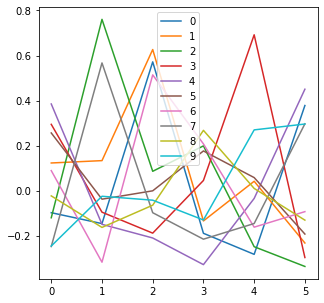

In [8]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

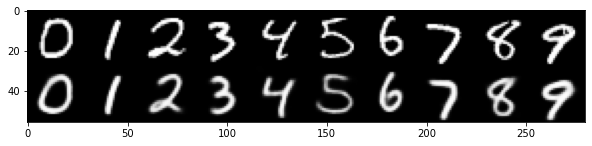

In [9]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [10]:
from XAE.sampler import gaus

exn = 5

In [11]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

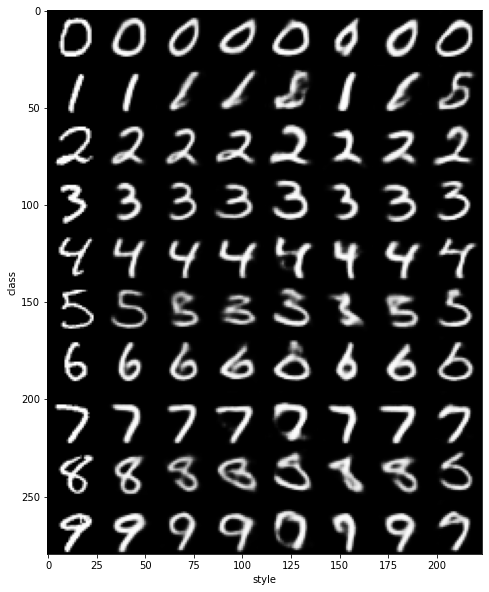

In [12]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [13]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

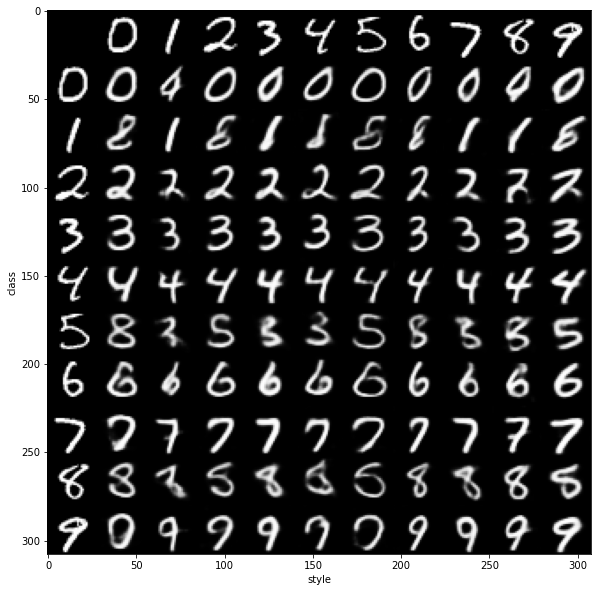

In [14]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()